# **PEACH LEAF DISEASE DETECTION**

IMPORTING MODULES

In [ ]:
import cv2
import os
import numpy as np
from skimage import color,data,restoration
from math import log10,sqrt
from scipy import signal
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Major1/Dataset'

folders = []
for root,dirs,files in os.walk(path):
  for dir in dirs:
    folders.append(os.path.join(root,dir))

**FILTERING**

Filtering is a method which is used to enhance the image. 

There are so many filtering methods. In this project we used mean, median, gaussian, unsharp, wiener, chmean, amsharp, laplacian,  log,admed, midpoint and gabor filters. After applying all the filters,we will pick the best filters interms of metrics like PSNR, SSIM and MSE.

PSNR (Peak Signal to Noise Ratio) is the ratio of max power of signal to max power of noise. 

SSIM (Structural Similarity Index Measurement) is used to measure similarity of pixels of original and modified image .

MSE (Mean Square Error) is used to calculate the squared error between pixels of original and modified image 

In [ ]:
def PSNR(old,new):
  mse = np.mean((old-new)**2)
  if(mse == 0):
    return 100
  max_pixel = 255.0
  psnr = 20*log10(max_pixel/sqrt(mse))
  return psnr


In [ ]:
from scipy.ndimage.filters import median_filter
def unsharp(image, sigma, strength):
  image_mf = median_filter(image, sigma)
  lap = cv2.Laplacian(image_mf,cv2.CV_64F)
  sharp = image-strength*lap
  sharp[sharp>255] = 255
  sharp[sharp<0] = 0    
  return sharp

In [ ]:
def weiner_filter(image1):
  psf = np.ones((3,3),np.float32)/9
  new_image = restoration.wiener(image1,psf,1100)
  return new_image


In [ ]:
from numba import njit,prange

# Adaptive Median Filter
@njit
def padding(img,pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
    padded_img[pad:-pad,pad:-pad] = img
    return padded_img

@njit(parallel=True)
def AdaptiveMedianFilter(img,s=3,sMax=7):
    if len(img.shape) == 3:
        raise Exception ("Single channel image only")

    H,W = img.shape
    a = sMax//2
    padded_img = padding(img,a)

    f_img = np.zeros(padded_img.shape)

    for i in prange(a,H+a+1):
        for j in range(a,W+a+1):
            value = Lvl_A(padded_img,i,j,s,sMax)
            f_img[i,j] = value

    return f_img[a:-a,a:-a] 

@njit
def Lvl_A(mat,x,y,s,sMax):
    window = mat[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    Zmin = np.min(window)
    Zmed = np.median(window)
    Zmax = np.max(window)

    A1 = Zmed - Zmin
    A2 = Zmed - Zmax

    if A1 > 0 and A2 < 0:
        return Lvl_B(window, Zmin, Zmed, Zmax)
    else:
        s += 2 
        if s <= sMax:
            return Lvl_A(mat,x,y,s,sMax)
        else:
             return Zmed

@njit
def Lvl_B(window, Zmin, Zmed, Zmax):
    h,w = window.shape

    Zxy = window[h//2,w//2]
    B1 = Zxy - Zmin
    B2 = Zxy - Zmax

    if B1 > 0 and B2 < 0 :
        return Zxy
    else:
        return Zmed

In [ ]:
from scipy.ndimage import maximum_filter, minimum_filter

def midpoint(img):
    maxf = maximum_filter(img, (3, 3))
    minf = minimum_filter(img, (3, 3))
    midpoint = (maxf + minf) / 2
    return midpoint

In [ ]:
def contraharmonic_mean(img, size, Q):
    num = np.power(img, Q + 1)
    denom = np.power(img, Q)
    kernel = np.full(size, 1.0)
    result = cv2.filter2D(num, -1, kernel) / cv2.filter2D(denom, -1, kernel)
    return result


In [ ]:
# Gabor Filter
def Gabor_filter(K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
	d = K_size // 2
	gabor = np.zeros((K_size, K_size), dtype=np.float32)
	for y in range(K_size):
		for x in range(K_size):
			px = x - d
			py = y - d
			theta = angle / 180. * np.pi
			_x = np.cos(theta) * px + np.sin(theta) * py
			_y = -np.sin(theta) * px + np.cos(theta) * py
			gabor[y, x] = np.exp(-(_x**2 + Gamma**2 * _y**2) / (2 * Sigma**2)) * np.cos(2*np.pi*_x/Lambda + Psi)
	gabor /= np.sum(np.abs(gabor))
	return gabor



def Gabor_filtering(gray, K_size=111, Sigma=10, Gamma=1.2, Lambda=10, Psi=0, angle=0):
    H, W = gray.shape
    gray = np.pad(gray, (K_size//2, K_size//2), 'edge')
    out = np.zeros((H, W), dtype=np.float32)
    gabor = Gabor_filter(K_size=K_size, Sigma=Sigma, Gamma=Gamma, Lambda=Lambda, Psi=0, angle=angle)
    for y in range(H):
        for x in range(W):
            out[y, x] = np.sum(gray[y : y + K_size, x : x + K_size] * gabor)
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    return out


def Gabor_process(img):
    H, W = img.shape
    gray = img
    As = [0,30,60,90,120,150]
    out = np.zeros([H, W], dtype=np.float32)
    for i, A in enumerate(As):
        _out = Gabor_filtering(gray, K_size=11, Sigma=1.5, Gamma=1.2, Lambda=3, angle=A)
        out += _out
    out = out / out.max() * 255
    out = out.astype(np.uint8)
    return out


In [ ]:
psnr_head = ['psnr_mean','psnr_median','psnr_gaussian','psnr_unsharp','psnr_wiener','psnr_chmean','psnr_amsharp',
           'psnr_laplacian','psnr_log','psnr_admed','psnr_midpoint','psnr_gabor']
ssim_head = ['ssim_mean','ssim_median','ssim_gaussian','ssim_unsharp','ssim_wiener','ssim_chmean','ssim_amsharp',
             'ssim_laplacian','ssim_log','ssim_admed','ssim_midpoint','ssim_gabor']
mse_head = ['mse_mean','mse_median','mse_gaussian','mse_unsharp','mse_wiener','mse_chmean','mse_amsharp',
             'mse_laplacian','mse_log','mse_admed','mse_midpoint','mse_gabor']

df_HL_psnr = pd.DataFrame(columns=psnr_head)
df_HL_ssim = pd.DataFrame(columns=ssim_head)
df_HL_mse = pd.DataFrame(columns=mse_head)

df_D_psnr = pd.DataFrame(columns=psnr_head)
df_D_ssim = pd.DataFrame(columns=ssim_head)
df_D_mse = pd.DataFrame(columns=mse_head)

for dir in folders:
  for _,_,files in os.walk(dir):
    for f in files:

# Diseases data set      
      if("HL" in f):
        image = cv2.imread(os.path.join(dir,f))
        # mean filter
        kernel = np.ones((3,3),np.float32)/9
        mean_image = cv2.filter2D(image,-1,kernel)
        psnr_mean = PSNR(image,mean_image)
        ssim_mean = ssim(image,mean_image,multichannel=True)
        mse_mean = mse(image,mean_image)

        # median filter
        median_image = cv2.medianBlur(image,9)
        psnr_median = PSNR(image,median_image)
        ssim_median = ssim(image,median_image,multichannel=True)
        mse_median = mse(image,median_image)
        
        # gaussian filter
        gaussian_image = cv2.GaussianBlur(image,(5,5),0)
        psnr_gaussian = PSNR(image,gaussian_image)
        ssim_gaussian = ssim(image,gaussian_image,multichannel=True)
        mse_gaussian = mse(image,gaussian_image)
        
        # unsharp mask filter
        sharp = np.zeros_like(image)
        for i in range(3):
          sharp[:,:,i] = unsharp(image[:,:,i], 5, 0.8)
        psnr_unsharp = PSNR(image,sharp)
        ssim_unsharp = ssim(image,sharp,multichannel=True)
        mse_unsharp = mse(image,sharp)
        
        # wiener filter
        wiener_image = np.ones_like(image)
        for i in range(3):
          wiener_image[:,:,i] = weiner_filter(wiener_image[:,:,i])
        psnr_wiener = PSNR(image,wiener_image)
        ssim_wiener = ssim(image,wiener_image,multichannel=True)
        mse_wiener = mse(image,wiener_image)

        # contraharmonic mean filter
        chmean_image = contraharmonic_mean(image,(3,3),0.5)
        psnr_chmean = PSNR(image,chmean_image)
        ssim_chmean = ssim(image,chmean_image,multichannel=True)
        mse_chmean = mse(image,chmean_image)

        # Arithmetic filter with sharpening kernel
        kernel_sharpening = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])
        amsharp_image = cv2.filter2D(image, -1, kernel_sharpening)
        psnr_amsharp = PSNR(image,amsharp_image)
        ssim_amsharp = ssim(image,amsharp_image,multichannel=True)
        mse_amsharp = mse(image,amsharp_image)

        # gray scale images
        bwimage = cv2.imread(os.path.join(dir,f),cv2.IMREAD_GRAYSCALE)
        # Laplacian Filter 
        dest = cv2.Laplacian(bwimage, cv2.CV_16S, ksize=3)
        laplacian_image = cv2.convertScaleAbs(dest)
        psnr_laplacian = PSNR(bwimage,laplacian_image)
        ssim_laplacian = ssim(bwimage,laplacian_image)
        mse_laplacian = mse(bwimage,laplacian_image)

        # LoG Filter
        gaussian_image = cv2.GaussianBlur(bwimage,(5,5),0)
        dest = cv2.Laplacian(gaussian_image, cv2.CV_64F, ksize=3)
        log_image = cv2.convertScaleAbs(dest)
        psnr_log = PSNR(bwimage,log_image)
        ssim_log = ssim(bwimage,log_image)
        mse_log = mse(bwimage,log_image)
        
        # Adaptive Median Filter
        admed_image = AdaptiveMedianFilter(bwimage)
        psnr_admed = PSNR(bwimage,admed_image)
        ssim_admed = ssim(bwimage,admed_image)
        mse_admed = mse(bwimage,admed_image)
        
        # Midpoint Filter
        midpoint_image = midpoint(bwimage)
        psnr_midpoint = PSNR(bwimage,midpoint_image)
        ssim_midpoint = ssim(bwimage,midpoint_image)
        mse_midpoint = mse(bwimage,midpoint_image)
        
        # Gabor Filter
      #  gabor_image = Gabor_process(bwimage)
       # psnr_gabor = PSNR(bwimage,gabor_image)
        #ssim_gabor = ssim(bwimage,gabor_image)
        #mse_gabor = mse(bwimage,gabor_image)
        
        df_HL_psnr = df_HL_psnr.append({'psnr_mean':psnr_mean,'psnr_median':psnr_median,
                                        'psnr_gaussian':psnr_gaussian,'psnr_unsharp':psnr_unsharp,
                                        'psnr_wiener':psnr_wiener,'psnr_chmean':psnr_chmean,'psnr_amsharp':psnr_amsharp,
                                        'psnr_laplacian':psnr_laplacian,'psnr_log':psnr_log,'psnr_admed':psnr_admed,
                                        'psnr_midpoint':psnr_midpoint},ignore_index=True)
        df_HL_ssim = df_HL_ssim.append({'ssim_mean':ssim_mean,'ssim_median':ssim_median,
                                        'ssim_gaussian':ssim_gaussian,'ssim_unsharp':ssim_unsharp,
                                        'ssim_wiener':ssim_wiener,'ssim_chmean':ssim_chmean,'ssim_amsharp':ssim_amsharp,
                                        'ssim_laplacian':ssim_laplacian,'ssim_log':ssim_log,'ssim_admed':ssim_admed,
                                        'ssim_midpoint':ssim_midpoint},ignore_index=True)
        df_HL_mse = df_HL_mse.append({'mse_mean':mse_mean,'mse_median':mse_median,
                                        'mse_gaussian':mse_gaussian,'mse_unsharp':mse_unsharp,
                                        'mse_wiener':mse_wiener,'mse_chmean':mse_chmean,'mse_amsharp':mse_amsharp,
                                        'mse_laplacian':mse_laplacian,'mse_log':mse_log,'mse_admed':mse_admed,
                                        'mse_midpoint':mse_midpoint},ignore_index=True)
        print(".",end="")

# Healthy Data Set      
      elif("S" in f): 
        image = cv2.imread(os.path.join(dir,f))
        # mean filter
        kernel = np.ones((3,3),np.float32)/9
        mean_image = cv2.filter2D(image,-1,kernel)
        psnr_mean = PSNR(image,mean_image)
        ssim_mean = ssim(image,mean_image,multichannel=True)
        mse_mean = mse(image,mean_image)

        # median filter
        median_image = cv2.medianBlur(image,9)
        psnr_median = PSNR(image,median_image)
        ssim_median = ssim(image,median_image,multichannel=True)
        mse_median = mse(image,median_image)
        
        # gaussian filter
        gaussian_image = cv2.GaussianBlur(image,(5,5),0)
        psnr_gaussian = PSNR(image,gaussian_image)
        ssim_gaussian = ssim(image,gaussian_image,multichannel=True)
        mse_gaussian = mse(image,gaussian_image)
        
        # unsharp mask filter
        sharp = np.zeros_like(image)
        for i in range(3):
          sharp[:,:,i] = unsharp(image[:,:,i], 5, 0.8)
        psnr_unsharp = PSNR(image,sharp)
        ssim_unsharp = ssim(image,sharp,multichannel=True)
        mse_unsharp = mse(image,sharp)
        
        # wiener filter
        wiener_image = np.ones_like(image)
        for i in range(3):
          wiener_image[:,:,i] = weiner_filter(wiener_image[:,:,i])
        psnr_wiener = PSNR(image,wiener_image)
        ssim_wiener = ssim(image,wiener_image,multichannel=True)
        mse_wiener = mse(image,wiener_image)

        # contraharmonic mean filter
        chmean_image = contraharmonic_mean(image,(3,3),0.5)
        psnr_chmean = PSNR(image,chmean_image)
        ssim_chmean = ssim(image,chmean_image,multichannel=True)
        mse_chmean = mse(image,chmean_image)

        # Arithmetic filter with sharpening kernel
        kernel_sharpening = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])
        amsharp_image = cv2.filter2D(image, -1, kernel_sharpening)
        psnr_amsharp = PSNR(image,amsharp_image)
        ssim_amsharp = ssim(image,amsharp_image,multichannel=True)
        mse_amsharp = mse(image,amsharp_image)

        # gray scale images
        bwimage = cv2.imread(os.path.join(dir,f),cv2.IMREAD_GRAYSCALE)
        # Laplacian Filter 
        dest = cv2.Laplacian(bwimage, cv2.CV_16S, ksize=3)
        laplacian_image = cv2.convertScaleAbs(dest)
        psnr_laplacian = PSNR(bwimage,laplacian_image)
        ssim_laplacian = ssim(bwimage,laplacian_image)
        mse_laplacian = mse(bwimage,laplacian_image)

        # LoG Filter
        gaussian_image = cv2.GaussianBlur(bwimage,(5,5),0)
        dest = cv2.Laplacian(gaussian_image, cv2.CV_64F, ksize=3)
        log_image = cv2.convertScaleAbs(dest)
        psnr_log = PSNR(bwimage,log_image)
        ssim_log = ssim(bwimage,log_image)
        mse_log = mse(bwimage,log_image)
        
        # Adaptive Median Filter
        admed_image = AdaptiveMedianFilter(bwimage)
        psnr_admed = PSNR(bwimage,admed_image)
        ssim_admed = ssim(bwimage,admed_image)
        mse_admed = mse(bwimage,admed_image)
        
        # Midpoint Filter
        midpoint_image = midpoint(bwimage)
        psnr_midpoint = PSNR(bwimage,midpoint_image)
        ssim_midpoint = ssim(bwimage,midpoint_image)
        mse_midpoint = mse(bwimage,midpoint_image)
        
        # Gabor Filter
       # gabor_image = Gabor_process(bwimage)
        #psnr_gabor = PSNR(bwimage,gabor_image)
        #ssim_gabor = ssim(bwimage,gabor_image)
        #mse_gabor = mse(bwimage,gabor_image)
        df_D_psnr = df_D_psnr.append({'psnr_mean':psnr_mean,'psnr_median':psnr_median,
                                        'psnr_gaussian':psnr_gaussian,'psnr_unsharp':psnr_unsharp,
                                        'psnr_wiener':psnr_wiener,'psnr_chmean':psnr_chmean,'psnr_amsharp':psnr_amsharp,
                                        'psnr_laplacian':psnr_laplacian,'psnr_log':psnr_log,'psnr_admed':psnr_admed,
                                        'psnr_midpoint':psnr_midpoint},ignore_index=True)
        df_D_ssim = df_D_ssim.append({'ssim_mean':ssim_mean,'ssim_median':ssim_median,
                                        'ssim_gaussian':ssim_gaussian,'ssim_unsharp':ssim_unsharp,
                                        'ssim_wiener':ssim_wiener,'ssim_chmean':ssim_chmean,'ssim_amsharp':ssim_amsharp,
                                        'ssim_laplacian':ssim_laplacian,'ssim_log':ssim_log,'ssim_admed':ssim_admed,
                                        'ssim_midpoint':ssim_midpoint},ignore_index=True)
        df_D_mse = df_D_mse.append({'mse_mean':mse_mean,'mse_median':mse_median,
                                        'mse_gaussian':mse_gaussian,'mse_unsharp':mse_unsharp,
                                        'mse_wiener':mse_wiener,'mse_chmean':mse_chmean,'mse_amsharp':mse_amsharp,
                                        'mse_laplacian':mse_laplacian,'mse_log':mse_log,'mse_admed':mse_admed,
                                        'mse_midpoint':mse_midpoint},ignore_index=True)
        


/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


.

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


....................................................................................................................................................................................................................................................................................................................................................................

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:204: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


In [ ]:
df_HL_psnr.describe()

,psnr_mean,psnr_median,psnr_gaussian,psnr_unsharp,psnr_wiener,psnr_chmean,psnr_amsharp,psnr_laplacian,psnr_log,psnr_admed,psnr_midpoint,psnr_gabor
count,360.000000,360.000000,360.000000,360.000000,360.000000,242.000000,360.000000,360.000000,360.000000,360.000000,360.000000,0.0
mean,30.910136,30.508969,31.010499,34.408575,27.986216,25.277952,28.185292,27.958286,28.064984,28.009261,8.098407,NaN
std,0.848954,0.567314,0.789071,0.595943,0.158166,1.454978,0.177763,0.061168,0.150981,1.450811,0.801468,NaN
min,29.748387,29.548351,29.851279,33.056793,27.576961,22.412379,27.909228,27.808651,27.618197,25.113069,6.677685,NaN
25%,30.462693,30.179027,30.575258,34.041368,27.887632,24.534489,28.084660,27.920064,27.969680,27.209826,7.577057,NaN
50%,30.827344,30.453567,30.915695,34.354105,27.983044,25.157589,28.160571,27.954659,28.062332,27.848997,7.950126,NaN
75%,31.240842,30.776626,31.340619,34.728062,28.098683,25.806159,28.252234,27.996238,28.154689,28.647128,8.442658,NaN
max,42.028349,36.281042,40.683503,38.115093,28.456037,40.949707,30.272670,28.272836,28.459628,45.328866,12.819754,NaN


In [ ]:
df_HL_ssim.describe()

,ssim_mean,ssim_median,ssim_gaussian,ssim_unsharp,ssim_wiener,ssim_chmean,ssim_amsharp,ssim_laplacian,ssim_log,ssim_admed,ssim_midpoint,ssim_gabor
count,360.000000,360.000000,360.000000,360.000000,360.000000,242.000000,360.000000,360.000000,360.000000,360.000000,360.000000,0.0
mean,0.611891,0.478859,0.640529,0.937244,0.002074,0.607465,0.336519,0.036368,0.052654,0.802505,0.242713,NaN
std,0.057739,0.060628,0.051522,0.003255,0.001981,0.059300,0.022382,0.011441,0.017212,0.031556,0.048335,NaN
min,0.471980,0.338161,0.516648,0.929175,0.000151,0.463143,0.295976,0.014953,0.018826,0.728517,0.107500,NaN
25%,0.573083,0.439139,0.605381,0.934962,0.000722,0.569424,0.323574,0.028275,0.040360,0.781383,0.213012,NaN
50%,0.611955,0.477870,0.640217,0.937196,0.001389,0.608914,0.333356,0.034593,0.050118,0.803226,0.236773,NaN
75%,0.645350,0.511776,0.670718,0.939134,0.002625,0.641030,0.346648,0.042225,0.062423,0.821442,0.267163,NaN
max,0.980760,0.906275,0.976332,0.962757,0.010473,0.980309,0.583189,0.101585,0.139512,0.993631,0.523018,NaN


In [ ]:
df_HL_mse.describe()

,mse_mean,mse_median,mse_gaussian,mse_unsharp,mse_wiener,mse_chmean,mse_amsharp,mse_laplacian,mse_log,mse_admed,mse_midpoint,mse_gabor
count,360.000000,360.000000,360.000000,360.000000,360.000000,242.000000,360.000000,360.000000,360.000000,360.000000,360.000000,0.0
mean,186.325360,241.942451,171.944968,91.893989,18790.596462,200.273292,4358.386527,10755.042920,15838.622071,106.878147,10229.720140,NaN
std,41.525058,50.595709,37.501628,17.951808,2403.078753,45.938439,633.899963,1632.314936,2237.872706,25.430990,1642.790063,NaN
min,4.152929,24.673314,5.737879,15.023219,10090.361938,5.225282,276.048426,5890.053665,8304.243820,1.906311,3397.073574,NaN
25%,158.476306,209.147747,146.962877,81.415391,17368.698542,170.790855,3965.951427,9774.248287,14546.163513,88.790726,9307.104793,NaN
50%,185.906136,238.745679,171.080409,92.659683,19004.157946,198.299453,4391.620448,10825.943558,15994.717468,106.703995,10424.820511,NaN
75%,212.424885,273.485477,195.414469,105.157349,20208.972104,228.892436,4771.134064,11755.567051,17247.243900,123.622669,11359.917322,NaN
max,340.565236,427.561137,314.113388,132.271942,26965.718730,373.114775,5792.127207,16312.281921,23717.942078,200.342667,13973.714123,NaN


In [ ]:
df_D_psnr.describe()

,psnr_mean,psnr_median,psnr_gaussian,psnr_unsharp,psnr_wiener,psnr_chmean,psnr_amsharp,psnr_laplacian,psnr_log,psnr_admed,psnr_midpoint,psnr_gabor
count,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,890.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,0.0
mean,33.083622,31.961117,33.152764,36.255001,28.139528,29.803364,28.413947,28.004021,28.173615,32.409986,10.155083,NaN
std,1.965854,1.419062,1.905049,1.617864,0.286547,3.047143,0.409681,0.178473,0.312749,3.454853,2.646627,NaN
min,29.002855,28.881892,29.099479,31.993783,27.404224,20.987146,27.812834,27.531215,27.492727,23.186784,6.139991,NaN
25%,31.512175,30.848190,31.640186,35.066734,27.935274,27.903144,28.114413,27.892446,27.953669,29.987989,8.738195,NaN
50%,32.987135,31.916509,33.100555,36.378786,28.098092,30.041324,28.310957,27.973290,28.127015,32.686249,9.695890,NaN
75%,34.344522,32.892510,34.417996,37.433180,28.294365,31.947767,28.613670,28.082855,28.350362,34.828959,10.905323,NaN
max,43.934238,38.728119,42.863086,41.153172,29.875009,37.892121,31.495643,29.983926,30.590427,44.748078,36.965663,NaN


In [ ]:
df_D_ssim.describe()

,ssim_mean,ssim_median,ssim_gaussian,ssim_unsharp,ssim_wiener,ssim_chmean,ssim_amsharp,ssim_laplacian,ssim_log,ssim_admed,ssim_midpoint,ssim_gabor
count,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,890.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,0.0
mean,0.746776,0.599097,0.760935,0.947964,0.001474,0.744097,0.337487,0.031585,0.041702,0.873428,0.354909,NaN
std,0.103918,0.116619,0.093402,0.006858,0.002177,0.102809,0.038879,0.015989,0.017280,0.055173,0.130371,NaN
min,0.382178,0.222652,0.431461,0.927371,0.000106,0.391652,0.267016,-0.024201,-0.017493,0.678625,0.059954,NaN
25%,0.676504,0.517174,0.698598,0.942901,0.000473,0.676525,0.309980,0.020577,0.030172,0.836280,0.267698,NaN
50%,0.761913,0.612172,0.774659,0.947740,0.000796,0.761283,0.330896,0.031009,0.040270,0.881577,0.342994,NaN
75%,0.824369,0.684897,0.830240,0.952967,0.001589,0.822612,0.354812,0.041420,0.051627,0.915240,0.428508,NaN
max,0.982048,0.922790,0.978653,0.972843,0.034834,0.931957,0.610228,0.105862,0.123352,0.991920,0.899975,NaN


In [ ]:
df_D_mse.describe()

,mse_mean,mse_median,mse_gaussian,mse_unsharp,mse_wiener,mse_chmean,mse_amsharp,mse_laplacian,mse_log,mse_admed,mse_midpoint,mse_gabor
count,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,890.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,0.0
mean,89.778981,142.695601,83.621887,39.507547,14840.301498,88.048494,2812.872999,9114.667740,12982.152341,51.288713,7025.636385,NaN
std,72.492654,92.506213,65.610851,23.596059,2918.807075,71.758341,1233.074048,2093.039590,2681.127332,44.954666,2670.074177,NaN
min,2.863866,16.720230,3.768295,5.749146,5822.799281,10.564969,181.295222,4038.072845,4198.449768,2.179077,13.077179,NaN
25%,40.815735,78.613363,39.471939,22.956289,13065.874959,41.524434,1863.261724,7728.493439,11418.314758,21.388702,5278.956383,NaN
50%,63.860016,113.799179,60.313446,32.083735,14568.432566,64.409240,2606.847046,8947.891876,12808.348068,35.031235,6974.151600,NaN
75%,114.343363,176.272268,105.706599,48.616938,16267.755407,105.382356,3699.771612,10287.809479,14315.169464,65.205078,8694.825878,NaN
max,491.362518,605.943944,440.480479,146.601730,41654.719767,518.042943,6725.243083,28667.383972,38007.358170,312.177750,15815.440205,NaN


In [ ]:
df_HL_psnr.to_csv('/content/drive/MyDrive/Major1/PSNR_Healthy_Public.csv',index=False)
df_HL_ssim.to_csv('/content/drive/MyDrive/Major1/SSIM_Healthy_Public.csv',index=False)
df_HL_mse.to_csv('/content/drive/MyDrive/Major1/MSE_Healthy_Public.csv',index=False)

In [ ]:
df_D_psnr.to_csv('/content/drive/MyDrive/Major1/PSNR_Diseased_Public.csv',index=False)
df_D_ssim.to_csv('/content/drive/MyDrive/Major1/SSIM_Diseased_Public.csv',index=False)
df_D_mse.to_csv('/content/drive/MyDrive/Major1/MSE_Diseased_Public.csv',index=False)

After applying the above filters, We got optimal metrics for Gaussian and Unsharp filters. So we will consider these filtered images and perform segmentation on them.

**SEGMENTATION**

Segemntation is the method used to extract the object from the image.

In this Segmentation process, we use Kmeans and otsu segmantation techniques 

In [ ]:
path = '/content/drive/MyDrive/Major1/Dataset'

folders = []
for root,dirs,files in os.walk(path):
  for dir in dirs:
    folders.append(os.path.join(root,dir))
for dir in folders:
  for _,_,files in os.walk(dir):
    for f in files:

# Diseases data set      
      if("S" in f):
        image = cv2.imread(os.path.join(dir,f))
        # gaussian filter
        gaussian_image = cv2.GaussianBlur(image,(5,5),0)
        
        # unsharp mask filter
        sharp = np.zeros_like(image)
        for i in range(3):
          sharp[:,:,i] = unsharp(image[:,:,i], 5, 0.8)
        
        cv2.imwrite('/content/drive/MyDrive/Major1/Filtered_Data/Gaussian_Diseased/gaussian_'+f,gaussian_image)
        cv2.imwrite('/content/drive/MyDrive/Major1/Filtered_Data/Unsharp_Diseased/unsharp_'+f,sharp)

# Healthy Data Set      
      elif("HL" in f): 
        image = cv2.imread(os.path.join(dir,f))
        # gaussian filter
        gaussian_image = cv2.GaussianBlur(image,(5,5),0)
        
        # unsharp mask filter
        sharp = np.zeros_like(image)
        for i in range(3):
          sharp[:,:,i] = unsharp(image[:,:,i], 5, 0.8)
        
        cv2.imwrite('/content/drive/MyDrive/Major1/Filtered_Data/Gaussian_Healthy/gaussian_'+f,gaussian_image)
        cv2.imwrite('/content/drive/MyDrive/Major1/Filtered_Data/Unsharp_Healthy/unsharp_'+f,sharp)



In [ ]:
import cv2
import numpy as np
from math import log10,sqrt
import skimage
from skimage import color,filters,viewer
import os
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [ ]:
def otsu(img):
  blur = color.rgb2gray(img)
  t = filters.threshold_otsu(blur)
  mask = blur < t
  out = np.zeros_like(img)
  out[mask] = img[mask]
  return out

In [ ]:
def kmeans(img):
  image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pixel_values = image.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  k = 2
  _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  centers = np.uint8(centers)
  labels = labels.flatten()
  segmented_image = centers[labels.flatten()]
  segmented_image = segmented_image.reshape(image.shape)
  masked_image = np.copy(image)
  masked_image = masked_image.reshape((-1, 3))
  cluster = 1
  masked_image[labels == cluster] = [0, 0, 0]
  masked_image = masked_image.reshape(image.shape)
  masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
  return masked_image

In [ ]:
path = '/content/drive/MyDrive/Major1/Filtered_Data'
folders = []
for root,dirs,files in os.walk(path):
  for dir in dirs:
    folders.append(os.path.join(root,dir))

In [ ]:
psnr_head_gaussian = ['psnr_gaussian_otsu','psnr_gaussian_kmeans']
ssim_head_gaussian = ['ssim_gaussian_otsu','ssim_gaussian_kmeans']
mse_head_gaussian = ['mse_gaussian_otsu','mse_gaussian_kmeans']

df_Gau_HL_psnr = pd.DataFrame(columns=psnr_head_gaussian)
df_Gau_HL_ssim = pd.DataFrame(columns=ssim_head_gaussian)
df_Gau_HL_mse = pd.DataFrame(columns=mse_head_gaussian)

df_Gau_D_psnr = pd.DataFrame(columns=psnr_head_gaussian)
df_Gau_D_ssim = pd.DataFrame(columns=ssim_head_gaussian)
df_Gau_D_mse = pd.DataFrame(columns=mse_head_gaussian)

psnr_head_unsharp = ['psnr_unsharp_otsu','psnr_unsharp_kmeans']
ssim_head_unsharp = ['ssim_unsharp_otsu','ssim_unsharp_kmeans']
mse_head_unsharp = ['mse_unsharp_otsu','mse_unsharp_kmeans']

df_US_HL_psnr = pd.DataFrame(columns=psnr_head_unsharp)
df_US_HL_ssim = pd.DataFrame(columns=ssim_head_unsharp)
df_US_HL_mse = pd.DataFrame(columns=mse_head_unsharp)

df_US_D_psnr = pd.DataFrame(columns=psnr_head_unsharp)
df_US_D_ssim = pd.DataFrame(columns=ssim_head_unsharp)
df_US_D_mse = pd.DataFrame(columns=mse_head_unsharp)

In [ ]:
#PSNR Function
def PSNR(old,new):
  mse = np.mean((old-new)**2)
  if(mse == 0):
    return 100
  max_pixel = 255.0
  psnr = 20*log10(max_pixel/sqrt(mse))
  return psnr


In [ ]:
for dir in folders:
  for _,_,files in os.walk(dir):
    for f in files:
# Gaussian Diseases data set      
      if("S" in f and "gaussian" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_gaussian_otsu = PSNR(image,out1)
        ssim_gaussian_otsu = ssim(image,out1,multichannel=True)
        mse_gaussian_otsu = mse(image,out1)

        psnr_gaussian_kmeans = PSNR(image,out)
        ssim_gaussian_kmeans = ssim(image,out,multichannel=True)
        mse_gaussian_kmeans = mse(image,out)

        df_Gau_D_psnr = df_Gau_D_psnr.append({'psnr_gaussian_otsu':psnr_gaussian_otsu,'psnr_gaussian_kmeans':psnr_gaussian_kmeans},ignore_index=True)
        df_Gau_D_ssim = df_Gau_D_ssim.append({'ssim_gaussian_otsu':ssim_gaussian_otsu,'ssim_gaussian_kmeans':ssim_gaussian_kmeans},ignore_index=True)
        df_Gau_D_mse = df_Gau_D_mse.append({'mse_gaussian_otsu':mse_gaussian_otsu,'mse_gaussian_kmeans':mse_gaussian_kmeans},ignore_index=True)

        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Otsu_Gaussian_Diseased/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Kmeans_Gaussian_Diseased/kmeans_'+f,out)
        print("1",end="")
# unsharp Diseases data set      
      elif("S" in f and "unsharp" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_unsharp_otsu = PSNR(image,out1)
        ssim_unsharp_otsu = ssim(image,out1,multichannel=True)
        mse_unsharp_otsu = mse(image,out1)

        psnr_unsharp_kmeans = PSNR(image,out)
        ssim_unsharp_kmeans = ssim(image,out,multichannel=True)
        mse_unsharp_kmeans = mse(image,out)

        df_US_D_psnr = df_US_D_psnr.append({'psnr_unsharp_otsu':psnr_unsharp_otsu,'psnr_unsharp_kmeans':psnr_unsharp_kmeans},ignore_index=True)
        df_US_D_ssim = df_US_D_ssim.append({'ssim_unsharp_otsu':ssim_unsharp_otsu,'ssim_unsharp_kmeans':ssim_unsharp_kmeans},ignore_index=True)
        df_US_D_mse = df_US_D_mse.append({'mse_unsharp_otsu':mse_unsharp_otsu,'mse_unsharp_kmeans':mse_unsharp_kmeans},ignore_index=True)
        
        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Otsu_Unsharp_Diseased/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Kmeans_Unsharp_Diseased/kmeans_'+f,out)
        print("2",end="")

# Gaussian Healthy data set      
      elif("HL" in f and "gaussian" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_gaussian_otsu = PSNR(image,out1)
        ssim_gaussian_otsu = ssim(image,out1,multichannel=True)
        mse_gaussian_otsu = mse(image,out1)

        psnr_gaussian_kmeans = PSNR(image,out)
        ssim_gaussian_kmeans = ssim(image,out,multichannel=True)
        mse_gaussian_kmeans = mse(image,out)

        df_Gau_HL_psnr = df_Gau_HL_psnr.append({'psnr_gaussian_otsu':psnr_gaussian_otsu,'psnr_gaussian_kmeans':psnr_gaussian_kmeans},ignore_index=True)
        df_Gau_HL_ssim = df_Gau_HL_ssim.append({'ssim_gaussian_otsu':ssim_gaussian_otsu,'ssim_gaussian_kmeans':ssim_gaussian_kmeans},ignore_index=True)
        df_Gau_HL_mse = df_Gau_HL_mse.append({'mse_gaussian_otsu':mse_gaussian_otsu,'mse_gaussian_kmeans':mse_gaussian_kmeans},ignore_index=True)

        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Otsu_Gaussian_Healthy/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Kmeans_Gaussian_Healthy/kmeans_'+f,out)
        print("3",end="")

# unsharp Healthy data set      
      elif("HL" in f and "unsharp" in f):
        image = cv2.imread(os.path.join(dir,f))
        out1 = otsu(image)
        out = kmeans(image)
        
        psnr_unsharp_otsu = PSNR(image,out1)
        ssim_unsharp_otsu = ssim(image,out1,multichannel=True)
        mse_unsharp_otsu = mse(image,out1)

        psnr_unsharp_kmeans = PSNR(image,out)
        ssim_unsharp_kmeans = ssim(image,out,multichannel=True)
        mse_unsharp_kmeans = mse(image,out)

        df_US_HL_psnr = df_US_HL_psnr.append({'psnr_unsharp_otsu':psnr_unsharp_otsu,'psnr_unsharp_kmeans':psnr_unsharp_kmeans},ignore_index=True)
        df_US_HL_ssim = df_US_HL_ssim.append({'ssim_unsharp_otsu':ssim_unsharp_otsu,'ssim_unsharp_kmeans':ssim_unsharp_kmeans},ignore_index=True)
        df_US_HL_mse = df_US_HL_mse.append({'mse_unsharp_otsu':mse_unsharp_otsu,'mse_unsharp_kmeans':mse_unsharp_kmeans},ignore_index=True)

        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Otsu_Unsharp_Healthy/otsu_'+f,out1)
        cv2.imwrite('/content/drive/MyDrive/Major1/Segmented_Data/Kmeans_Unsharp_Healthy/kmeans_'+f,out)
        print("4",end="")

1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

In [ ]:
df_Gau_HL_psnr.describe() 

,psnr_gaussian_otsu,psnr_gaussian_kmeans
count,360.000000,360.000000
mean,29.280423,31.649990
std,0.484735,2.514637
min,28.133235,28.478848
25%,28.908817,29.337245
50%,29.282060,30.660481
75%,29.538037,33.942738
max,31.344489,37.692405


In [ ]:
df_Gau_HL_ssim.describe()

,ssim_gaussian_otsu,ssim_gaussian_kmeans
count,360.000000,360.000000
mean,0.131413,0.445204
std,0.061635,0.311479
min,0.015350,0.018845
25%,0.087533,0.132905
50%,0.115076,0.406188
75%,0.164955,0.759551
max,0.443016,0.911115


In [ ]:
df_Gau_HL_mse.describe()

,mse_gaussian_otsu,mse_gaussian_kmeans
count,360.000000,360.000000
mean,17607.916687,9229.054147
std,2442.764758,8482.607161
min,9403.459473,176.982564
25%,16005.379559,774.435895
50%,17669.118276,6483.730512
75%,19118.586541,17648.894986
max,25371.357951,22379.805969


In [ ]:
df_Gau_D_psnr.describe()

,psnr_gaussian_otsu,psnr_gaussian_kmeans
count,2297.000000,2297.000000
mean,30.507287,31.355467
std,1.042727,1.449576
min,27.901160,28.358999
25%,29.791760,30.230848
50%,30.440960,31.140599
75%,31.131200,32.340494
max,39.110080,36.936584


In [ ]:
df_Gau_D_ssim.describe()

,ssim_gaussian_otsu,ssim_gaussian_kmeans
count,2297.000000,2297.000000
mean,0.241044,0.435579
std,0.126436,0.193742
min,-0.007044,0.035560
25%,0.144479,0.263098
50%,0.228062,0.435784
75%,0.317931,0.605550
max,0.924588,0.842181


In [ ]:
df_Gau_D_mse.describe()

,mse_gaussian_otsu,mse_gaussian_kmeans
count,2297.000000,2297.000000
mean,12116.304502,7285.490648
std,3186.576528,5020.261878
min,3703.308100,264.204152
25%,9996.456548,2628.394430
50%,11720.168432,6362.907471
75%,13785.923055,11380.682220
max,39983.716761,25578.692469


In [ ]:
df_US_HL_psnr.describe()

,psnr_unsharp_otsu,psnr_unsharp_kmeans
count,360.000000,360.000000
mean,29.235113,31.930722
std,0.444433,2.759420
min,28.283090,28.310568
25%,28.897648,29.225981
50%,29.190989,32.124141
75%,29.446153,34.607465
max,31.110233,37.931146


In [ ]:
df_US_HL_ssim.describe()

,ssim_unsharp_otsu,ssim_unsharp_kmeans
count,360.000000,360.000000
mean,0.064185,0.435629
std,0.049307,0.355582
min,-0.049980,-0.022110
25%,0.032398,0.067848
50%,0.054597,0.582145
75%,0.092153,0.797769
max,0.275729,0.916337


In [ ]:
df_US_HL_mse.describe()

,mse_unsharp_otsu,mse_unsharp_kmeans
count,360.000000,360.000000
mean,18159.507551,9231.047058
std,2449.242702,8860.037829
min,9407.393916,121.461344
25%,16609.364262,603.344499
50%,18318.604301,2286.680628
75%,19702.190014,18184.404732
max,26121.543706,25883.108068


In [ ]:
df_US_D_psnr.describe()

,psnr_unsharp_otsu,psnr_unsharp_kmeans
count,2297.000000,2297.000000
mean,30.360419,31.348042
std,0.927496,1.555111
min,27.949695,28.189010
25%,29.726174,30.139274
50%,30.319654,31.053000
75%,30.929422,32.369093
max,39.250989,38.475179


In [ ]:
df_US_D_ssim.describe()

,ssim_unsharp_otsu,ssim_unsharp_kmeans
count,2297.000000,2297.000000
mean,0.110133,0.381134
std,0.093661,0.240027
min,-0.113131,-0.051714
25%,0.044839,0.151034
50%,0.095094,0.385529
75%,0.156662,0.602038
max,0.922111,0.901533


In [ ]:
df_US_D_mse.describe()

,mse_unsharp_otsu,mse_unsharp_kmeans
count,2297.000000,2297.000000
mean,12534.471685,7538.991370
std,3213.139001,5455.776220
min,3709.093664,208.279195
25%,10437.935877,2362.005397
50%,12035.015864,6828.263977
75%,14149.453237,11951.583104
max,41022.820058,31145.311005


In [ ]:
df_Gau_HL_psnr.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/PSNR_Healthy_Gaussian.csv',index=False) 
df_Gau_HL_ssim.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/SSIM_Healthy_Gaussian.csv',index=False)
df_Gau_HL_mse.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/MSE_Healthy_Gaussian.csv',index=False)

df_Gau_D_psnr.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/PSNR_Diseased_Gaussian.csv',index=False)
df_Gau_D_ssim.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/SSIM_Diseased_Gaussian.csv',index=False)
df_Gau_D_mse.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/MSE_Diseased_Gaussian.csv',index=False)

df_US_HL_psnr.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/PSNR_Healthy_Unsharp.csv',index=False)
df_US_HL_ssim.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/SSIM_Healthy_Unsharp.csv',index=False)
df_US_HL_mse.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/MSE_Healthy_Unsharp.csv',index=False)

df_US_D_psnr.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/PSNR_Diseased_Unsharp.csv',index=False)
df_US_D_ssim.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/SSIM_Diseased_Unsharp.csv',index=False)
df_US_D_mse.to_csv('/content/drive/MyDrive/Major1/Segmented_Data/MSE_Diseased_Unsharp.csv',index=False)

**FEATURE EXTRACTION**

Feature Extraction is the process of retrieving the features from the images.
In this project we use GLCM (Gray Level Co-occurence Matrix) technique to extract features from images. It is a way of extracting second order statistical texture features. 

In [ ]:
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
from skimage.feature import greycomatrix,greycoprops
from skimage.measure import label,regionprops
import skimage
import os
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.metrics import accuracy_score


In [ ]:
slices=[]
proList = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy']
featlist = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy','hue','value', 'saturaton','path','label']
properties =np.zeros(6)
glcmMatrix = []
final=[]
crop = "Public_Dataset"
folders = ["Kmeans_Gaussian_Diseased","Kmeans_Gaussian_Healthy"]
for folder in folders:
    print(folder)
    labell=folders.index(folder)
    INPUT_SCAN_FOLDER="/content/drive/MyDrive/Major1/Segmented_Data/"+folder+"/"
    
    image_folder_list = os.listdir(INPUT_SCAN_FOLDER)
    for i in range(len(image_folder_list)):
        abc =cv2.imread(INPUT_SCAN_FOLDER+image_folder_list[i])
        gray_image = cv2.cvtColor(abc, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(abc, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        h_mean = np.mean(h)


        h_mean = np.mean(h_mean)
        s_mean = np.mean(s)
        s_mean = np.mean(s_mean)
        v_mean = np.mean(v)
        v_mean = np.mean(v_mean)
        print(image_folder_list[i])
        glcmMatrix = (greycomatrix(gray_image, [1], [0], levels=2 ** 8))
        path_img="/content/drive/MyDrive/Major1/GLCM_Images/"+folder+"/GLCM_"+image_folder_list[i]
        pyplot.imsave(path_img,gray_image)
        for j in range(0, len(proList)):
            properties[j] = (greycoprops(glcmMatrix, prop=proList[j]))
        features = np.array(
            [properties[0], properties[1], properties[2], properties[3], properties[4],h_mean,s_mean,v_mean,INPUT_SCAN_FOLDER+image_folder_list[i],labell])
        final.append(features)
df = pd.DataFrame(final, columns=featlist)
df.to_csv("/content/drive/MyDrive/Major1/Kmeans_Gaussian_GLCM_Features.csv")

Kmeans_Gaussian_Diseased
kmeans_gaussian_9e2441ee-a102-4a91-b5eb-f22a6d887233___Rut._Bact.S 1115.JPG
kmeans_gaussian_a3b4a6e5-1c8f-4ba2-81a5-5ce59d40ded2___Rutg._Bact.S 2045.JPG
kmeans_gaussian_9a3ca1ad-277e-430f-8fa7-a82d21d0aedb___Rut._Bact.S 1094.JPG
kmeans_gaussian_9af37227-e637-40f9-976a-a16932b796c7___Rut._Bact.S 1522.JPG
kmeans_gaussian_a5f2555f-407e-4545-9030-cbaa96aae216___Rutg._Bact.S 1185.JPG
kmeans_gaussian_a462459d-35a2-4d21-bd50-65bbdab7b6e4___Rut._Bact.S 1476.JPG
kmeans_gaussian_a1fa06d2-2f2f-44df-a6cd-bf4d00d8a2cf___Rut._Bact.S 1053.JPG
kmeans_gaussian_9f7c97e6-d9ff-4a31-a38a-30aeb4a2eeec___Rut._Bact.S 1067.JPG
kmeans_gaussian_a54c257d-3823-4cb8-90e8-fb416ae0b064___Rutg._Bact.S 1767.JPG
kmeans_gaussian_9bd43ac8-76fe-4c5b-a7eb-10134ebed5c0___Rutg._Bact.S 1488.JPG
kmeans_gaussian_a2f81059-9171-41d2-acca-ef3d02d81438___Rut._Bact.S 1209.JPG
kmeans_gaussian_a6b1b5d7-99a1-40fd-8639-0f2e4719c327___Rutg._Bact.S 1402.JPG
kmeans_gaussian_937b943f-7609-4109-ac1f-662d6a48936c___Rut

In [ ]:
abc=pd.read_csv('/content/drive/MyDrive/Major1/Kmeans_Gaussian_GLCM_Features.csv')
abc=abc.drop('path',axis=1)
abc=abc.drop('Unnamed: 0',axis=1)
X=abc.loc[ : , abc.columns != 'label']
y=abc['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=17) 

model = []
saved = []
models = []
results = []
names = []
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier(n_estimators=50, max_features=8, max_depth=8)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='kd_tree')))
models.append(("GB",GradientBoostingClassifier(n_estimators=50, learning_rate=1, max_features=5, max_depth=9, random_state=0)))
models.append(("ADA",AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=0)))
models.append(("MLP",MLPClassifier(hidden_layer_sizes=(8,8),max_iter=100,activation='relu',random_state=1)))
for name,model in models:
    
 
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    names.append(name)
    results.append(score*100)
    saved.append(model)
    print(name,score*100)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LR 93.10776942355889
LDA 93.23308270676691
CART 93.85964912280701
NB 91.8546365914787
SVM 87.468671679198
RF 96.49122807017544
KNN 92.60651629072682
GB 95.23809523809523
ADA 95.6140350877193
MLP 86.71679197994987


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
slices=[]
proList = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy']
featlist = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy','hue','value', 'saturaton','path','label']
properties =np.zeros(6)
glcmMatrix = []
final=[]
crop = "Public_Dataset"
folders = ["Kmeans_Unsharp_Diseased","Kmeans_Unsharp_Healthy"]
for folder in folders:
    print(folder)
    labell=folders.index(folder)
    INPUT_SCAN_FOLDER="/content/drive/MyDrive/Major1/Segmented_Data/"+folder+"/"
    image_folder_list = os.listdir(INPUT_SCAN_FOLDER)
    for i in range(len(image_folder_list)):
        abc =cv2.imread(INPUT_SCAN_FOLDER+image_folder_list[i])
        gray_image = cv2.cvtColor(abc, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(abc, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        h_mean = np.mean(h)


        h_mean = np.mean(h_mean)
        s_mean = np.mean(s)
        s_mean = np.mean(s_mean)
        v_mean = np.mean(v)
        v_mean = np.mean(v_mean)
        print(image_folder_list[i])
        glcmMatrix = (greycomatrix(gray_image, [1], [0], levels=2 ** 8))
        path_img="/content/drive/MyDrive/Major1/GLCM_Images/"+folder+"/GLCM_"+image_folder_list[i]
        pyplot.imsave(path_img,gray_image)
        for j in range(0, len(proList)):
            properties[j] = (greycoprops(glcmMatrix, prop=proList[j]))
        features = np.array(
            [properties[0], properties[1], properties[2], properties[3], properties[4],h_mean,s_mean,v_mean,INPUT_SCAN_FOLDER+image_folder_list[i],labell])
        final.append(features)
df = pd.DataFrame(final, columns=featlist)
df.to_csv("/content/drive/MyDrive/Major1/Kmeans_Unsharp_GLCM_Features.csv")

Kmeans_Unsharp_Diseased
kmeans_unsharp_9e2441ee-a102-4a91-b5eb-f22a6d887233___Rut._Bact.S 1115.JPG
kmeans_unsharp_a3b4a6e5-1c8f-4ba2-81a5-5ce59d40ded2___Rutg._Bact.S 2045.JPG
kmeans_unsharp_9a3ca1ad-277e-430f-8fa7-a82d21d0aedb___Rut._Bact.S 1094.JPG
kmeans_unsharp_9af37227-e637-40f9-976a-a16932b796c7___Rut._Bact.S 1522.JPG
kmeans_unsharp_a5f2555f-407e-4545-9030-cbaa96aae216___Rutg._Bact.S 1185.JPG
kmeans_unsharp_a462459d-35a2-4d21-bd50-65bbdab7b6e4___Rut._Bact.S 1476.JPG
kmeans_unsharp_a1fa06d2-2f2f-44df-a6cd-bf4d00d8a2cf___Rut._Bact.S 1053.JPG
kmeans_unsharp_9f7c97e6-d9ff-4a31-a38a-30aeb4a2eeec___Rut._Bact.S 1067.JPG
kmeans_unsharp_a54c257d-3823-4cb8-90e8-fb416ae0b064___Rutg._Bact.S 1767.JPG
kmeans_unsharp_9bd43ac8-76fe-4c5b-a7eb-10134ebed5c0___Rutg._Bact.S 1488.JPG
kmeans_unsharp_a2f81059-9171-41d2-acca-ef3d02d81438___Rut._Bact.S 1209.JPG
kmeans_unsharp_a6b1b5d7-99a1-40fd-8639-0f2e4719c327___Rutg._Bact.S 1402.JPG
kmeans_unsharp_937b943f-7609-4109-ac1f-662d6a48936c___Rutg._Bact.S 1938

In [ ]:
abc=pd.read_csv('/content/drive/MyDrive/Major1/Kmeans_Unsharp_GLCM_Features.csv')
abc=abc.drop('path',axis=1)
abc=abc.drop('Unnamed: 0',axis=1)
X=abc.loc[ : , abc.columns != 'label']
y=abc['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=17) 

model = []
saved = []
models = []
results = []
names = []
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier(n_estimators=50, max_features=8, max_depth=8)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='kd_tree')))
models.append(("GB",GradientBoostingClassifier(n_estimators=50, learning_rate=1, max_features=5, max_depth=9, random_state=0)))
models.append(("ADA",AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=0)))
models.append(("MLP",MLPClassifier(hidden_layer_sizes=(8,8),max_iter=100,activation='relu',random_state=1)))
for name,model in models:
    
 
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    names.append(name)
    results.append(score*100)
    saved.append(model)
    print(name,score*100)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LR 91.22807017543859
LDA 91.60401002506265
CART 96.11528822055138
NB 90.97744360902256
SVM 86.46616541353383
RF 96.99248120300751
KNN 91.72932330827066
GB 96.61654135338345
ADA 96.11528822055138
MLP 86.46616541353383


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
slices=[]
proList = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy']
featlist = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy','hue','value', 'saturaton','path','label']
properties =np.zeros(6)
glcmMatrix = []
final=[]
crop = "Public_Dataset"
folders = ["Otsu_Gaussian_Diseased","Otsu_Gaussian_Healthy"]
for folder in folders:
    print(folder)
    labell=folders.index(folder)
    INPUT_SCAN_FOLDER="/content/drive/MyDrive/Major1/Segmented_Data/"+folder+"/"
    image_folder_list = os.listdir(INPUT_SCAN_FOLDER)
    for i in range(len(image_folder_list)):
        abc =cv2.imread(INPUT_SCAN_FOLDER+image_folder_list[i])
        gray_image = cv2.cvtColor(abc, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(abc, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        h_mean = np.mean(h)


        h_mean = np.mean(h_mean)
        s_mean = np.mean(s)
        s_mean = np.mean(s_mean)
        v_mean = np.mean(v)
        v_mean = np.mean(v_mean)
        print(image_folder_list[i])
        glcmMatrix = (greycomatrix(gray_image, [1], [0], levels=2 ** 8))
        path_img="/content/drive/MyDrive/Major1/GLCM_Images/"+folder+"/GLCM_"+image_folder_list[i]
        pyplot.imsave(path_img,gray_image)
        for j in range(0, len(proList)):
            properties[j] = (greycoprops(glcmMatrix, prop=proList[j]))
        features = np.array(
            [properties[0], properties[1], properties[2], properties[3], properties[4],h_mean,s_mean,v_mean,INPUT_SCAN_FOLDER+image_folder_list[i],labell])
        final.append(features)
df = pd.DataFrame(final, columns=featlist)
df.to_csv("/content/drive/MyDrive/Major1/Otsu_Gaussian_GLCM_Features.csv")

Otsu_Gaussian_Diseased
otsu_gaussian_9e2441ee-a102-4a91-b5eb-f22a6d887233___Rut._Bact.S 1115.JPG
otsu_gaussian_a3b4a6e5-1c8f-4ba2-81a5-5ce59d40ded2___Rutg._Bact.S 2045.JPG
otsu_gaussian_9a3ca1ad-277e-430f-8fa7-a82d21d0aedb___Rut._Bact.S 1094.JPG
otsu_gaussian_9af37227-e637-40f9-976a-a16932b796c7___Rut._Bact.S 1522.JPG
otsu_gaussian_a5f2555f-407e-4545-9030-cbaa96aae216___Rutg._Bact.S 1185.JPG
otsu_gaussian_a462459d-35a2-4d21-bd50-65bbdab7b6e4___Rut._Bact.S 1476.JPG
otsu_gaussian_a1fa06d2-2f2f-44df-a6cd-bf4d00d8a2cf___Rut._Bact.S 1053.JPG
otsu_gaussian_9f7c97e6-d9ff-4a31-a38a-30aeb4a2eeec___Rut._Bact.S 1067.JPG
otsu_gaussian_a54c257d-3823-4cb8-90e8-fb416ae0b064___Rutg._Bact.S 1767.JPG
otsu_gaussian_9bd43ac8-76fe-4c5b-a7eb-10134ebed5c0___Rutg._Bact.S 1488.JPG
otsu_gaussian_a2f81059-9171-41d2-acca-ef3d02d81438___Rut._Bact.S 1209.JPG
otsu_gaussian_a6b1b5d7-99a1-40fd-8639-0f2e4719c327___Rutg._Bact.S 1402.JPG
otsu_gaussian_937b943f-7609-4109-ac1f-662d6a48936c___Rutg._Bact.S 1938.JPG
otsu_gaus

In [ ]:
abc=pd.read_csv('/content/drive/MyDrive/Major1/Otsu_Gaussian_GLCM_Features.csv')
abc=abc.drop('path',axis=1)
abc=abc.drop('Unnamed: 0',axis=1)
X=abc.loc[ : , abc.columns != 'label']
y=abc['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=17) 

model = []
saved = []
models = []
results = []
names = []
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier(n_estimators=50, max_features=8, max_depth=8)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='kd_tree')))
models.append(("GB",GradientBoostingClassifier(n_estimators=50, learning_rate=1, max_features=5, max_depth=9, random_state=0)))
models.append(("ADA",AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=0)))
models.append(("MLP",MLPClassifier(hidden_layer_sizes=(8,8),max_iter=100,activation='relu',random_state=1)))
for name,model in models:
    
 
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    names.append(name)
    results.append(score*100)
    saved.append(model)
    print(name,score*100)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LR 95.98997493734336
LDA 94.48621553884712
CART 92.73182957393483
NB 81.45363408521304
SVM 91.10275689223057
RF 95.36340852130326
KNN 90.85213032581454
GB 95.86466165413535
ADA 94.48621553884712
MLP 92.60651629072682


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
slices=[]
proList = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy']
featlist = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy','hue','value', 'saturaton','path','label']
properties =np.zeros(6)
glcmMatrix = []
final=[]
crop = "Public_Dataset"
folders = ["Otsu_Unsharp_Diseased","Otsu_Unsharp_Healthy"]
for folder in folders:
    print(folder)
    labell=folders.index(folder)
    INPUT_SCAN_FOLDER="/content/drive/MyDrive/Major1/Segmented_Data/"+folder+"/"
    image_folder_list = os.listdir(INPUT_SCAN_FOLDER)
    for i in range(len(image_folder_list)):
        abc =cv2.imread(INPUT_SCAN_FOLDER+image_folder_list[i])
        gray_image = cv2.cvtColor(abc, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(abc, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        h_mean = np.mean(h)


        h_mean = np.mean(h_mean)
        s_mean = np.mean(s)
        s_mean = np.mean(s_mean)
        v_mean = np.mean(v)
        v_mean = np.mean(v_mean)
        print(image_folder_list[i])
        glcmMatrix = (greycomatrix(gray_image, [1], [0], levels=2 ** 8))
        path_img="/content/drive/MyDrive/Major1/GLCM_Images/"+folder+"/GLCM_"+image_folder_list[i]
        pyplot.imsave(path_img,gray_image)
        for j in range(0, len(proList)):
            properties[j] = (greycoprops(glcmMatrix, prop=proList[j]))
        features = np.array(
            [properties[0], properties[1], properties[2], properties[3], properties[4],h_mean,s_mean,v_mean,INPUT_SCAN_FOLDER+image_folder_list[i],labell])
        final.append(features)
df = pd.DataFrame(final, columns=featlist)
df.to_csv("/content/drive/MyDrive/Major1/Otsu_Unsharp_GLCM_Features.csv")

Otsu_Unsharp_Diseased
otsu_unsharp_9e2441ee-a102-4a91-b5eb-f22a6d887233___Rut._Bact.S 1115.JPG
otsu_unsharp_a3b4a6e5-1c8f-4ba2-81a5-5ce59d40ded2___Rutg._Bact.S 2045.JPG
otsu_unsharp_9a3ca1ad-277e-430f-8fa7-a82d21d0aedb___Rut._Bact.S 1094.JPG
otsu_unsharp_9af37227-e637-40f9-976a-a16932b796c7___Rut._Bact.S 1522.JPG
otsu_unsharp_a5f2555f-407e-4545-9030-cbaa96aae216___Rutg._Bact.S 1185.JPG
otsu_unsharp_a462459d-35a2-4d21-bd50-65bbdab7b6e4___Rut._Bact.S 1476.JPG
otsu_unsharp_a1fa06d2-2f2f-44df-a6cd-bf4d00d8a2cf___Rut._Bact.S 1053.JPG
otsu_unsharp_9f7c97e6-d9ff-4a31-a38a-30aeb4a2eeec___Rut._Bact.S 1067.JPG
otsu_unsharp_a54c257d-3823-4cb8-90e8-fb416ae0b064___Rutg._Bact.S 1767.JPG
otsu_unsharp_9bd43ac8-76fe-4c5b-a7eb-10134ebed5c0___Rutg._Bact.S 1488.JPG
otsu_unsharp_a2f81059-9171-41d2-acca-ef3d02d81438___Rut._Bact.S 1209.JPG
otsu_unsharp_a6b1b5d7-99a1-40fd-8639-0f2e4719c327___Rutg._Bact.S 1402.JPG
otsu_unsharp_937b943f-7609-4109-ac1f-662d6a48936c___Rutg._Bact.S 1938.JPG
otsu_unsharp_95a235fe-c

In [ ]:
abc=pd.read_csv('/content/drive/MyDrive/Major1/Otsu_Unsharp_GLCM_Features.csv')
abc=abc.drop('path',axis=1)
abc=abc.drop('Unnamed: 0',axis=1)
X=abc.loc[ : , abc.columns != 'label']
y=abc['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=17) 

model = []
saved = []
models = []
results = []
names = []
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier(n_estimators=50, max_features=8, max_depth=8)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='kd_tree')))
models.append(("GB",GradientBoostingClassifier(n_estimators=50, learning_rate=1, max_features=5, max_depth=9, random_state=0)))
models.append(("ADA",AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=0)))
models.append(("MLP",MLPClassifier(hidden_layer_sizes=(8,8),max_iter=100,activation='relu',random_state=1)))
for name,model in models:
    
 
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    names.append(name)
    results.append(score*100)
    saved.append(model)
    print(name,score*100)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LR 94.3609022556391
LDA 92.60651629072682
CART 92.23057644110276
NB 81.32832080200501
SVM 86.46616541353383
RF 95.73934837092732
KNN 88.22055137844612
GB 95.6140350877193
ADA 94.61152882205513
MLP 89.3483709273183


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
abc=pd.read_csv('/content/drive/MyDrive/Major1/Kmeans_Unsharp_GLCM_Features.csv')
abc=abc.drop('path',axis=1)
abc=abc.drop('Unnamed: 0',axis=1)
X=abc.loc[ : , abc.columns != 'label']
y=abc['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=17) 

model = []
saved = []
models = []
results = []
names = []
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier(n_estimators=50, max_features=8, max_depth=8)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='kd_tree')))
models.append(("GB",GradientBoostingClassifier(n_estimators=50, learning_rate=1, max_features=5, max_depth=9, random_state=0)))
models.append(("ADA",AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=0)))
models.append(("MLP",MLPClassifier(hidden_layer_sizes=(8,8),max_iter=100,activation='relu',random_state=1)))
for name,model in models:
    
 
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    names.append(name)
    results.append(score*100)
    saved.append(model)
    print(name,score*100)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LR 91.22807017543859
LDA 91.60401002506265
CART 96.11528822055138
NB 90.97744360902256
SVM 86.46616541353383
RF 96.8671679197995
KNN 91.72932330827066
GB 96.61654135338345
ADA 96.11528822055138
MLP 86.46616541353383


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
for column in X.columns:
    feature = np.array(X[column]).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(feature)
    feature_scaled = scaler.transform(feature)
    X[column] = feature_scaled.reshape(1,-1)[0]
model = []
saved = []
models = []
results = []
names = []
models.append(('LR',LogisticRegression()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC()))
models.append(('RF',RandomForestClassifier(n_estimators=50)))
models.append(("KNN",KNeighborsClassifier(n_neighbors=1, weights='uniform', algorithm='kd_tree')))
models.append(("GB",GradientBoostingClassifier(n_estimators=250, learning_rate=1, max_features=7, max_depth=8, random_state=0)))
models.append(("ADA",AdaBoostClassifier(n_estimators=100,learning_rate=1,random_state=10)))
models.append(("MLP",MLPClassifier(hidden_layer_sizes=(8,8,8),max_iter=300,activation='relu',random_state=1)))
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=17) 

for name,model in models:
    
 
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    names.append(name)
    results.append(score*100)
    saved.append(model)
    print(name,score*100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

LR 88.7218045112782
LDA 91.60401002506265
CART 95.98997493734336
NB 90.6015037593985
SVM 95.11278195488721
RF 96.8671679197995
KNN 95.23809523809523
GB 96.2406015037594
ADA 96.11528822055138
MLP 96.2406015037594


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
rfc = RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32]
    
}

In [ ]:
from sklearn.model_selection import GridSearchCV
cv1 = GridSearchCV(rfc,parameters,cv=5)
cv1.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv1)

Best parameters are: {'max_depth': 32, 'n_estimators': 100}


0.9 + or -0.008 for the {'max_depth': 2, 'n_estimators': 5}
0.894 + or -0.009 for the {'max_depth': 2, 'n_estimators': 10}
0.901 + or -0.008 for the {'max_depth': 2, 'n_estimators': 50}
0.899 + or -0.009 for the {'max_depth': 2, 'n_estimators': 100}
0.898 + or -0.008 for the {'max_depth': 2, 'n_estimators': 250}
0.939 + or -0.009 for the {'max_depth': 4, 'n_estimators': 5}
0.947 + or -0.004 for the {'max_depth': 4, 'n_estimators': 10}
0.947 + or -0.008 for the {'max_depth': 4, 'n_estimators': 50}
0.947 + or -0.007 for the {'max_depth': 4, 'n_estimators': 100}
0.946 + or -0.007 for the {'max_depth': 4, 'n_estimators': 250}
0.949 + or -0.006 for the {'max_depth': 8, 'n_estimators': 5}
0.954 + or -0.011 for the {'max_depth': 8, 'n_estimators': 10}
0.96 + or -0.008 for the {'max_depth': 8, 'n_estimators': 50}
0.961 + or -0.009 for the {'max_depth': 8, 'n_estimators': 100}
0.961 + or -0.01 for the {'max_depth': 8, 'n_estimators':

In [ ]:
rfc = GradientBoostingClassifier()
parameters = {
    'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001],
                         'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [ ]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv)

Best parameters are: {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 250}


0.917 + or -0.021 for the {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 5}
0.946 + or -0.011 for the {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 10}
0.954 + or -0.01 for the {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 50}
0.961 + or -0.007 for the {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 100}
0.96 + or -0.008 for the {'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 250}
0.948 + or -0.008 for the {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 5}
0.948 + or -0.01 for the {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 10}
0.955 + or -0.008 for the {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 50}
0.96 + or -0.005 for the {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100}
0.962 + or -0.009 for the {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 250}
0.947 + or -0.009 for the {'learning_rate': 0.15, 'max_dep

Accuracy of the RF on test set: 0.967
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       690
           1       0.97      0.79      0.87       108

    accuracy                           0.97       798
   macro avg       0.97      0.89      0.92       798
weighted avg       0.97      0.97      0.97       798



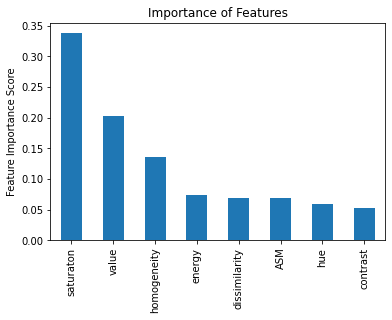

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
new=RandomForestClassifier(n_estimators=50,max_depth=16)
new.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the RF on test set: {:.3f}'.format(new.score(X_test, y_test)))
pred=new.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
from sklearn.metrics import confusion_matrix
cfm=confusion_matrix(y_test,pred)
print(cfm)

[[687   3]
 [ 23  85]]


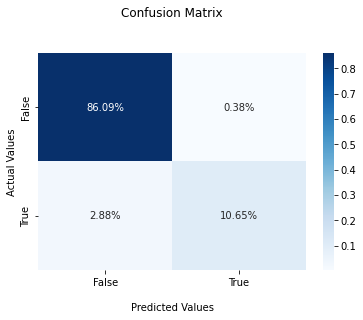

In [ ]:
import seaborn as sns
ax=sns.heatmap(cfm/np.sum(cfm),annot=True,fmt='.2%',cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()